In [ ]:
import numpy as np
import cv2
from scipy.constants import c, pi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from ipywidgets import widgets, interactive, fixed
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from tqdm import tqdm
import matplotlib.gridspec as gridspec

# uncomment for inline matlab style interactive figures
# %matplotlib widget 

%cd ".."
import simulation as sim
import fft_shift as fft_shift
from utils import rmse, create_mask, calculate_snr
from fig_setup import fig_setup

fig_setup() # comment this if using matplotlib widget because they conflict

#### Useful parameters

In [2]:
mod_freq = 60 # MHz
wavelength = 940 # nm
integration_time = 500 # ns
k_deg = 90
k = np.deg2rad(k_deg)
calib_offset = 624.5 # mm
cropX = 0
cropY = 0
phase_variation_axis="x"

unambig_dist = (c*0.5)/(mod_freq *1e6)
coeff_to_rad = unambig_dist / (2.0 * pi)

#### Load data

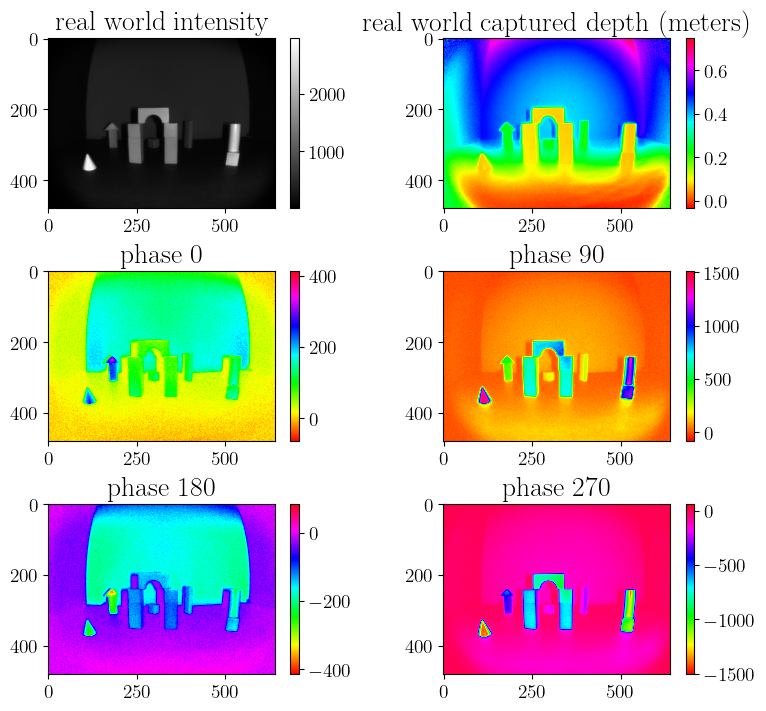

In [3]:
with np.load('data/emulation/dist_amp.npz') as gt_data:
    depth_rw = ((gt_data['dist'] - calib_offset) * 1e-3)[cropY:, cropX:] # divide by 1e3 to get meters
    intensity_rw = gt_data['amp'][cropY:, cropX:]
    
with np.load('data/emulation/phase_data.npz') as phase_data:
    I0_rw = phase_data['phase0'][cropY:, cropX:]
    I90_rw = phase_data['phase90'][cropY:, cropX:]
    I180_rw = phase_data['phase180'][cropY:, cropX:]
    I270_rw = phase_data['phase270'][cropY:, cropX:]
    
phase_rw = (depth_rw / coeff_to_rad) - pi # calculate the phase from the depth according to the mlx datasheet

# show the real world data
fig_rw, axs = plt.subplots(3,2, figsize=(8,7), layout="constrained")
im = axs[0,0].imshow(intensity_rw, cmap="gray")
axs[0,0].set_title("real world intensity")
fig_rw.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(depth_rw, cmap="hsv")
axs[0,1].set_title("real world captured depth (meters)")
fig_rw.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(I0_rw, cmap="hsv")
axs[1,0].set_title("phase 0")
fig_rw.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(I90_rw, cmap="hsv")
axs[1,1].set_title("phase 90")
fig_rw.colorbar(im, ax=axs[1,1])

im = axs[2,0].imshow(I180_rw, cmap="hsv")
axs[2,0].set_title("phase 180")
fig_rw.colorbar(im, ax=axs[2,0])

im = axs[2,1].imshow(I270_rw, cmap="hsv")
axs[2,1].set_title("phase 270")
fig_rw.colorbar(im, ax=axs[2,1])

#### Make experimental run

In [4]:
intensity_rw = intensity_rw[cropX:, cropY:]
depth_rw = depth_rw[cropX:, cropY:]
phase_rw = phase_rw[cropX:, cropY:]
using_sigmas = np.linspace(0, 6.9, num=70)

k = np.deg2rad(360/4)
snrs_intensity = []
snrs_phase = []

snrs_intensity2d = []
snrs_phase2d = []

recon_intensities = []
recon_phases = []

diff_intensities = []
diff_phases = []

recon_intensities2d = []
recon_phases2d = []

diff_intensities2d = []
diff_phases2d = []

for i in tqdm(range(len(using_sigmas))):
    sigma = using_sigmas[i]
    
    # create a simulation
    fft_shift_sim = fft_shift.FFT_Shift(k, 
                                        intensity_rw, depth_rw,
                                        omega = 2 * pi * (mod_freq * 1e6))

    # computationally create quad intensity measurements
    fft_shift_sim.create_quad_intensity(method='mlx')
    computed_phases = [fft_shift_sim.I0, fft_shift_sim.I90, fft_shift_sim.I180, fft_shift_sim.I270]

    # compute phase from quad measurements
    quad_bin_phase = fft_shift_sim.compute_phase_conventional()
        
    # use mlx's equation for calculating depth from quad measurements
    quad_bin_depth = (quad_bin_phase + pi) * coeff_to_rad
    
    """ 
        1D prefiltering
    """
    # compute emulated image intensity
    fft_shift_sim.create_composite_intensity(phase_variation_axis=phase_variation_axis, use_Gaussian='1d', sigma=sigma, method='mlx') 

    composite_intensity = fft_shift_sim.composite_image

    # calculate the fft shift
    fft_shift_sim.calculate_fft_shifted(phase_variation_axis=phase_variation_axis)

    # reconstruct and scale intensity, phase, depth from fft shift
    recon_intensity = 2 * fft_shift_sim.reconstruct_intensity()
    recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)
    recon_depth = ((c * (recon_phase + pi)) / (4 * pi * mod_freq * 1e6))
    
    recon_intensities.append(recon_intensity)
    recon_phases.append(recon_phase)
    
    diff_intensities.append(intensity_rw - recon_intensity)
    diff_phases.append(phase_rw - recon_phase)
    
    snrs_intensity.append(calculate_snr(intensity_rw, recon_intensity))
    snrs_phase.append(calculate_snr(phase_rw, recon_phase))

    """ 
        2D prefiltering
    """
    
    fft_shift_sim.create_composite_intensity(phase_variation_axis=phase_variation_axis, use_Gaussian='2d', sigma=sigma, method='mlx') # data slices
    fft_shift_sim.calculate_fft_shifted(phase_variation_axis=phase_variation_axis)

    # reconstruct and scale intensity, phase, depth from fft shift
    recon_intensity2d = 2 * fft_shift_sim.reconstruct_intensity()
    recon_phase2d = fft_shift_sim.reconstruct_phase() - (pi/2.0)
    
    recon_intensities2d.append(recon_intensity2d)
    recon_phases2d.append(recon_phase2d)
    
    diff_intensities2d.append(intensity_rw - recon_intensity2d)
    diff_phases2d.append(phase_rw - recon_phase2d)
    
    snrs_intensity2d.append(calculate_snr(intensity_rw, recon_intensity2d))#, n_bucket=(0, int(360/k_deg))))
    snrs_phase2d.append(calculate_snr(phase_rw, recon_phase2d))#, n_bucket=(0, int(360/k_deg))))

100%|███████████████████████████████████████████| 70/70 [00:19<00:00,  3.60it/s]


#### Plotting functions

Makes an interactive plot, or saves each frame 

In [5]:
if snrs_phase[i] == max(snrs_phase):
    text1d = 'green'
    color1d = 'limegreen'
    thickness1d = 4
    markersize1d= 80
    z1d = 1000
else:
    text1d ='k'
    color1d='blue'
    thickness1d = 1.5
    markersize1d= 40
    z1d = 1

if snrs_phase2d[i] == max(snrs_phase2d):
    text2d = 'green'
    color2d = 'limegreen'
    thickness2d = 4
    markersize2d= 80
    z2d = 1000
else:
    text2d = 'k'
    color2d='tab:red'
    thickness2d = 1.5
    markersize2d= 40
    z2d = 1


In [6]:
def interactive_plot_phase():
    i_slider = widgets.IntSlider(value = 0, min = 0, max = 69, step=1, layout = widgets.Layout(width = "80%"), continuous_update=False)
    slider_label = widgets.Label(value="index")
    slider_box = widgets.HBox([i_slider, slider_label])

    @widgets.interact(i = i_slider)
    def update(i):
    # uncomment the for loop below, and comment out the widget decorator/def update(i) to save each frame
    # for i in tqdm(range(len(using_sigmas))):    
        if snrs_phase[i] == max(snrs_phase):
            text1d = 'green'
            color1d = 'limegreen'
            thickness1d = 4
            markersize1d= 80
            z1d = 1000
        else:
            text1d ='k'
            color1d='blue'
            thickness1d = 1.5
            markersize1d= 40
            z1d = 1

        if snrs_phase2d[i] == max(snrs_phase2d):
            text2d = 'green'
            color2d = 'limegreen'
            thickness2d = 4
            markersize2d= 80
            z2d = 1000
        else:
            text2d = 'k'
            color2d='tab:red'
            thickness2d = 1.5
            markersize2d= 40
            z2d = 1

        fig_recon = plt.figure(layout='constrained', figsize=(12, 6.5))
        subfigs = fig_recon.subfigures(1, 2, wspace=0.1, width_ratios=[1, 1.5])    

        """
            sigma and ground truth phase plot
        """
        axs_left = subfigs[0].subplots(2,1)
        fig_recon.suptitle("Reconstructed Phase and Loss at $\sigma = $ {}\n$k =$ {}$^\circ$".format(round(using_sigmas[i],3),k_deg))

        img = axs_left[0].imshow(phase_rw, cmap="hsv", vmin = -pi, vmax=pi)
        axs_left[0].set_title("\nGT phase")
        axs_left[0].axis('off')
        subfigs[0].colorbar(img, ax=axs_left[0], location='left', pad=-0.1)

        axs_left[1].plot(using_sigmas, snrs_phase, linewidth=thickness1d, label="1D prefilter", color=color1d)
        axs_left[1].scatter(using_sigmas[i], snrs_phase[i], markersize1d, color=color1d, zorder=z1d)
        axs_left[1].plot(using_sigmas, snrs_phase2d, linewidth=thickness2d, label="2D prefilter", color=color2d)
        axs_left[1].scatter(using_sigmas[i], snrs_phase2d[i], markersize2d, color=color2d, zorder=z2d)
        axs_left[1].set_title("\n")
        axs_left[1].set_aspect(1/1.9, adjustable='box', anchor='SW')


        # formatting properties
        axs_left[1].set_xlabel("$\sigma$")
        axs_left[1].set_ylabel("SNR[dB]")
        axs_left[1].yaxis.tick_left()
        axs_left[1].yaxis.set_label_position('left')
        # axs_left[1].tick_params(labelsize=14)
        axs_left[1].legend()
        extent = axs_left[1].get_window_extent().transformed(fig_recon.dpi_scale_trans.inverted())

        # reconstructions plotting
        axs_right = subfigs[1].subplots(2,2)
        """
            1D plotting
        """

        img = axs_right[0,0].imshow(recon_phases[i], cmap="hsv", vmin = -pi, vmax=pi)
        axs_right[0,0].set_ylabel("1D kernel")
        axs_right[0,0].set_title("\nReconstruction")

        img = axs_right[0,1].imshow(diff_phases[i], cmap="hsv", vmin = -0.5, vmax=0.5)
        axs_right[0,1].annotate("SNR[dB]={:.3f}".format(snrs_phase[i]), (300,50), fontsize=16, backgroundcolor='w', color=text1d)
        axs_right[0,1].set_title("\nError")

        # draw box around 1d plots
        extent_ax1 = Bbox.union([ax.get_tightbbox() for ax in axs_right[0,:]])
        extent_ax1 = extent_ax1.transformed(fig_recon.transFigure.inverted())
        rect = FancyBboxPatch((extent_ax1.xmin+0.01, extent_ax1.ymin-0.105), extent_ax1.width+0.02, extent_ax1.height-0.05,
                        linewidth=thickness1d, boxstyle='round, pad=0.01', fill=False, color=color1d, zorder=10000, transform=fig_recon.transFigure)

        subfigs[1].patches.extend([rect])

        """
            2D plotting
        """
        img = axs_right[1,0].imshow(recon_phases2d[i], cmap="hsv", vmin = -pi, vmax=pi)
        axs_right[1,0].set_ylabel("2D kernel")

        img = axs_right[1,1].imshow(diff_phases2d[i], cmap="hsv", vmin = -0.5, vmax=0.5)
        axs_right[1,1].annotate("SNR[dB]={:.3f}".format(snrs_phase2d[i]), (300,50), fontsize=16, backgroundcolor='w', color=text2d)

        # draw box around 2d plots
        extent_ax2 = Bbox.union([ax.get_tightbbox() for ax in axs_right[1,:]])
        extent_ax2 = extent_ax2.transformed(fig_recon.transFigure.inverted())
        rect2 = FancyBboxPatch((extent_ax2.xmin+0.01, extent_ax2.ymin-0.088), extent_ax2.width+0.02, extent_ax2.height+0.03,
                        linewidth=thickness2d, boxstyle='round, pad=0.01', fill=False, color=color2d, zorder=10000, transform=fig_recon.transFigure)
        subfigs[1].patches.extend([rect2])

        # formatting properties, get rid of image axis spines and ticks
        for ax in axs_right[0,:]:
            ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )
            ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)

        for ax in axs_right[1,:]:
            ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )
            ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)

        # add error colorbar
        p0 = axs_right[0,1].get_position().get_points().flatten()
        p1 = axs_right[1,1].get_position().get_points().flatten()
        ax_cbar = subfigs[1].add_axes([p0[2]+0.125, 0, 0.02, p1[2]+0.01])
        cbar = plt.colorbar(img, cax=ax_cbar, orientation='vertical')
        cbar.ax.tick_params(labelsize=14)


In [7]:
def interactive_plot_intensity():
    i_slider = widgets.IntSlider(value = 0, min = 0, max = 69, step=1, layout = widgets.Layout(width = "80%"), continuous_update=False)
    slider_label = widgets.Label(value="index")
    slider_box = widgets.HBox([i_slider, slider_label])

    @widgets.interact(i = i_slider)
    def update(i):
    # uncomment the for loop below, and comment out the widget decorator/def update(i) to save each frame
    # for i in tqdm(range(len(using_sigmas))):    
        if snrs_intensity[i] == max(snrs_intensity):
            text1d = 'green'
            color1d = 'limegreen'
            thickness1d = 4
            markersize1d= 80
            z1d = 1000
        else:
            text1d ='k'
            color1d='blue'
            thickness1d = 1.5
            markersize1d= 40
            z1d = 1

        if snrs_intensity2d[i] == max(snrs_intensity2d):
            text2d = 'green'
            color2d = 'limegreen'
            thickness2d = 4
            markersize2d= 80
            z2d = 1000
        else:
            text2d = 'k'
            color2d='tab:red'
            thickness2d = 1.5
            markersize2d= 40
            z2d = 1

        fig_recon = plt.figure(layout='constrained', figsize=(12, 6.5))
        subfigs = fig_recon.subfigures(1, 2, wspace=0.1, width_ratios=[1, 1.5])    

        """
            sigma and ground truth intensity plot
        """
        axs_left = subfigs[0].subplots(2,1)
        fig_recon.suptitle("Reconstructed Intensity and Loss at $\sigma = $ {}\n$k =$ {}$^\circ$".format(round(using_sigmas[i],3),k_deg))

        img = axs_left[0].imshow(intensity_rw, cmap="gray", vmin = 0, vmax=3000)
        axs_left[0].set_title("\nGT Intensity")
        axs_left[0].axis('off')
        subfigs[0].colorbar(img, ax=axs_left[0], location='left', pad=-0.1)

        axs_left[1].plot(using_sigmas, snrs_intensity, linewidth=thickness1d, label="1D prefilter", color=color1d)
        axs_left[1].scatter(using_sigmas[i], snrs_intensity[i], markersize1d, color=color1d, zorder=z1d)
        axs_left[1].plot(using_sigmas, snrs_intensity2d, linewidth=thickness2d, label="2D prefilter", color=color2d)
        axs_left[1].scatter(using_sigmas[i], snrs_intensity2d[i], markersize2d, color=color2d, zorder=z2d)
        axs_left[1].set_title("\n")
        axs_left[1].set_aspect(1/4, adjustable='box', anchor='SW')


        # formatting properties
        axs_left[1].set_xlabel("$\sigma$")
        axs_left[1].set_ylabel("SNR[dB]")
        axs_left[1].yaxis.tick_left()
        axs_left[1].yaxis.set_label_position('left')
        # axs_left[1].tick_params(labelsize=14)
        axs_left[1].legend()
        extent = axs_left[1].get_window_extent().transformed(fig_recon.dpi_scale_trans.inverted())

        # reconstructions plotting
        axs_right = subfigs[1].subplots(2,2)
        """
            1D plotting
        """

        img = axs_right[0,0].imshow(recon_intensities[i], cmap="gray", vmin = 0, vmax=3000)
        axs_right[0,0].set_ylabel("1D kernel")
        axs_right[0,0].set_title("\nReconstruction")

        img = axs_right[0,1].imshow(diff_intensities[i], cmap="viridis", vmin = -400, vmax=400)
        axs_right[0,1].annotate("SNR[dB]={:.3f}".format(snrs_intensity[i]), (300,50), fontsize=16, backgroundcolor='w', color=text1d)
        axs_right[0,1].set_title("\nError")

        # draw box around 1d plots
        extent_ax1 = Bbox.union([ax.get_tightbbox() for ax in axs_right[0,:]])
        extent_ax1 = extent_ax1.transformed(fig_recon.transFigure.inverted())
        rect = FancyBboxPatch((extent_ax1.xmin+0.01, extent_ax1.ymin-0.105), extent_ax1.width+0.02, extent_ax1.height-0.05,
                        linewidth=thickness1d, boxstyle='round, pad=0.01', fill=False, color=color1d, zorder=10000, transform=fig_recon.transFigure)

        subfigs[1].patches.extend([rect])

        """
            2D plotting
        """
        img = axs_right[1,0].imshow(recon_intensities2d[i], cmap="gray", vmin = 0, vmax=3000)
        axs_right[1,0].set_ylabel("2D kernel")

        img = axs_right[1,1].imshow(diff_intensities2d[i], cmap="viridis", vmin = -400, vmax=400)
        axs_right[1,1].annotate("SNR[dB]={:.3f}".format(snrs_intensity2d[i]), (300,50), fontsize=16, backgroundcolor='w', color=text2d)

        # draw box around 2d plots
        extent_ax2 = Bbox.union([ax.get_tightbbox() for ax in axs_right[1,:]])
        extent_ax2 = extent_ax2.transformed(fig_recon.transFigure.inverted())
        rect2 = FancyBboxPatch((extent_ax2.xmin+0.01, extent_ax2.ymin-0.088), extent_ax2.width+0.02, extent_ax2.height+0.03,
                        linewidth=thickness2d, boxstyle='round, pad=0.01', fill=False, color=color2d, zorder=10000, transform=fig_recon.transFigure)
        subfigs[1].patches.extend([rect2])

        # formatting properties, get rid of image axis spines and ticks
        for ax in axs_right[0,:]:
            ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )
            ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)

        for ax in axs_right[1,:]:
            ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )
            ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)

        # add error colorbar
        p0 = axs_right[0,1].get_position().get_points().flatten()
        p1 = axs_right[1,1].get_position().get_points().flatten()
        ax_cbar = subfigs[1].add_axes([p0[2]+0.125, 0, 0.02, p1[2]+0.01])
        cbar = plt.colorbar(img, cax=ax_cbar, orientation='vertical')
        cbar.ax.tick_params(labelsize=14)


In [8]:
def save_frames():
    for i in tqdm(range(len(using_sigmas))):    
        fig_recon = plt.figure(layout='constrained', figsize=(12, 6.5))
        subfigs = fig_recon.subfigures(1, 2, wspace=0.1, width_ratios=[1, 1.5])    

        """
            sigma and ground truth phase plot
        """
        axs_left = subfigs[0].subplots(2,1)
        fig_recon.suptitle("Reconstructed Phase and Loss at $\sigma = $ {}\n$k =$ {}$^\circ$".format(round(using_sigmas[i],3),k_deg))

        img = axs_left[0].imshow(phase_rw, cmap="hsv", vmin = -pi, vmax=pi)
        axs_left[0].set_title("\nGT phase")
        axs_left[0].axis('off')
        subfigs[0].colorbar(img, ax=axs_left[0], location='left', pad=-0.1)

        axs_left[1].plot(using_sigmas, snrs_phase, linewidth=thickness1d, label="1D prefilter", color=color1d)
        axs_left[1].scatter(using_sigmas[i], snrs_phase[i], markersize1d, color=color1d, zorder=z1d)
        axs_left[1].plot(using_sigmas, snrs_phase2d, linewidth=thickness2d, label="2D prefilter", color=color2d)
        axs_left[1].scatter(using_sigmas[i], snrs_phase2d[i], markersize2d, color=color2d, zorder=z2d)
        axs_left[1].set_title("\n")
        axs_left[1].set_aspect(1/1.9, adjustable='box', anchor='SW')


        # formatting properties
        axs_left[1].set_xlabel("$\sigma$")
        axs_left[1].set_ylabel("SNR[dB]")
        axs_left[1].yaxis.tick_left()
        axs_left[1].yaxis.set_label_position('left')
        # axs_left[1].tick_params(labelsize=14)
        axs_left[1].legend()
        extent = axs_left[1].get_window_extent().transformed(fig_recon.dpi_scale_trans.inverted())

        # reconstructions plotting
        axs_right = subfigs[1].subplots(2,2)
        """
            1D plotting
        """

        img = axs_right[0,0].imshow(recon_phases[i], cmap="hsv", vmin = -pi, vmax=pi)
        axs_right[0,0].set_ylabel("1D kernel")
        axs_right[0,0].set_title("\nReconstruction")

        img = axs_right[0,1].imshow(diff_phases[i], cmap="hsv", vmin = -0.5, vmax=0.5)
        axs_right[0,1].annotate("SNR[dB]={:.3f}".format(snrs_phase[i]), (300,50), fontsize=16, backgroundcolor='w', color=text1d)
        axs_right[0,1].set_title("\nError")

        # draw box around 1d plots
        extent_ax1 = Bbox.union([ax.get_tightbbox() for ax in axs_right[0,:]])
        extent_ax1 = extent_ax1.transformed(fig_recon.transFigure.inverted())
        rect = FancyBboxPatch((extent_ax1.xmin+0.01, extent_ax1.ymin-0.105), extent_ax1.width+0.02, extent_ax1.height-0.05,
                        linewidth=thickness1d, boxstyle='round, pad=0.01', fill=False, color=color1d, zorder=10000, transform=fig_recon.transFigure)

        subfigs[1].patches.extend([rect])

        """
            2D plotting
        """
        img = axs_right[1,0].imshow(recon_phases2d[i], cmap="hsv", vmin = -pi, vmax=pi)
        axs_right[1,0].set_ylabel("2D kernel")

        img = axs_right[1,1].imshow(diff_phases2d[i], cmap="hsv", vmin = -0.5, vmax=0.5)
        axs_right[1,1].annotate("SNR[dB]={:.3f}".format(snrs_phase2d[i]), (300,50), fontsize=16, backgroundcolor='w', color=text2d)

        # draw box around 2d plots
        extent_ax2 = Bbox.union([ax.get_tightbbox() for ax in axs_right[1,:]])
        extent_ax2 = extent_ax2.transformed(fig_recon.transFigure.inverted())
        rect2 = FancyBboxPatch((extent_ax2.xmin+0.01, extent_ax2.ymin-0.088), extent_ax2.width+0.02, extent_ax2.height+0.03,
                        linewidth=thickness2d, boxstyle='round, pad=0.01', fill=False, color=color2d, zorder=10000, transform=fig_recon.transFigure)
        subfigs[1].patches.extend([rect2])

        # formatting properties, get rid of image axis spines and ticks
        for ax in axs_right[0,:]:
            ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )
            ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)

        for ax in axs_right[1,:]:
            ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
                )
            ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)

            # add error colorbar
            p0 = axs_right[0,1].get_position().get_points().flatten()
            p1 = axs_right[1,1].get_position().get_points().flatten()
            ax_cbar = subfigs[1].add_axes([p0[2]+0.125, 0, 0.02, p1[2]+0.01])
            cbar = plt.colorbar(img, cax=ax_cbar, orientation='vertical')
            cbar.ax.tick_params(labelsize=14)

            if save_figs:
                if i < 10:
                    fig_recon.savefig("notebooks/figure_generation/varying_sigma_k4/sigma0{}.png".format(i), bbox_inches = 'tight')
                else:
                    fig_recon.savefig("notebooks/figure_generation/varying_sigma_k4/sigma{}.png".format(i), bbox_inches = 'tight')
        plt.close()

In [9]:
save_figs = False
interactive_plot_phase()

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', layout=Layout(width='80%'),…

In [10]:
interactive_plot_intensity()

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', layout=Layout(width='80%'),…

## Extended visualization

#### Phase only

[ 0  7 10 27 44 69]


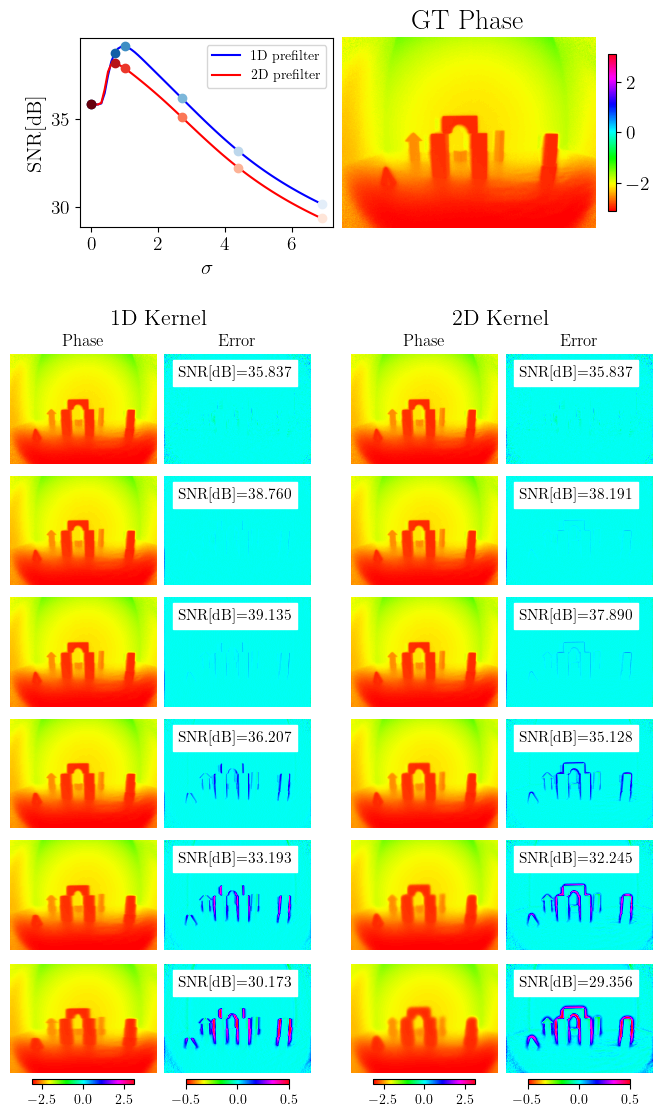

In [11]:
rows = 6
cols = 4
colors_1d = plt.cm.Blues_r(np.linspace(0,0.9,rows))
colors_2d = plt.cm.Reds_r(np.linspace(0,0.9,rows))

fig = plt.figure(layout='constrained', figsize=(6.5, 11))
subfig = fig.subfigures(2,1, height_ratios=[2, 6], hspace=0.05)

row_gts = subfig[0].subplots(1,2)
row_sigmas = subfig[1].subfigures(1, 2, wspace=0.1)

############ gt phase ############
ax = row_gts[1]
ax.set_title("GT Phase")
im = ax.imshow(phase_rw, cmap='hsv', vmin=-pi, vmax=pi)
fig.colorbar(im, ax=ax, shrink=0.75)
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )

############ all sigmas ############
ax = row_gts[0]
ax.plot(using_sigmas, snrs_phase, linewidth=1.5, label="1D prefilter", color='b')
ax.plot(using_sigmas, snrs_phase2d, linewidth=1.5, label="2D prefilter", color='red')
ax.set_aspect(1/1.9, adjustable='box', anchor='C')

# formatting properties
ax.set_xlabel("$\sigma$")
ax.set_ylabel("SNR[dB]")
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.legend()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# the varying sigmas
temp = np.array([0,7])
temp2 = np.arange(10, 60, int(70/(rows-2)))
indices = np.append(temp, temp2)
indices= np.append(indices,[69])
print(indices)

ax1d = row_sigmas[0].subplots(rows, 2)
row_sigmas[0].suptitle("1D Kernel", fontsize=16)
ax2d = row_sigmas[1].subplots(rows, 2)
row_sigmas[1].suptitle("2D Kernel", fontsize=16)

ax1d[0,0].set_title("Phase", fontsize=12)
ax1d[0,1].set_title("Error", fontsize=12)
ax2d[0,0].set_title("Phase", fontsize=12)
ax2d[0,1].set_title("Error", fontsize=12)

for r in range(0,rows):
    if r < rows:
        indx = indices[r]
    else:
        indx = indices[r+1]
        
    # make the gradient scatters on the snr plot    
    ax.scatter(using_sigmas[indx], snrs_phase[indx], color=colors_1d[r], zorder=10)
    ax.scatter(using_sigmas[indx], snrs_phase2d[indx], color=colors_2d[r],zorder=10)
    
    # plot the reconstructed phases
    im1d = ax1d[r,0].imshow(recon_phases[indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax1d[r,0].set_axis_off()

    im2d = ax2d[r,0].imshow(recon_phases2d[indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax2d[r,0].set_axis_off()
    
    # plot the errors
    im1d_err = ax1d[r,1].imshow(diff_phases[indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax1d[r,1].annotate("SNR[dB]={:.3f}".format(snrs_phase[indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax1d[r,1].set_axis_off()

    im2d_err = ax2d[r,1].imshow(diff_phases2d[indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax2d[r,1].annotate("SNR[dB]={:.3f}".format(snrs_phase2d[indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax2d[r,1].set_axis_off()
    
    if r == rows-1:
        cbar1 = row_sigmas[0].colorbar(im1d, ax=ax1d[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar2 = row_sigmas[0].colorbar(im1d_err, ax=ax1d[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        cbar3 = row_sigmas[0].colorbar(im2d, ax=ax2d[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar4 = row_sigmas[0].colorbar(im1d_err, ax=ax2d[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        
        cbar1.ax.tick_params(labelsize=10)
        cbar2.ax.tick_params(labelsize=10)
        cbar3.ax.tick_params(labelsize=10)
        cbar4.ax.tick_params(labelsize=10)

plt.show()

# fig.savefig("figures/varying_sigmas_static.pdf", bbox_inches = 'tight')

#### Intensity Only

[ 0  4  5 10 45 69]


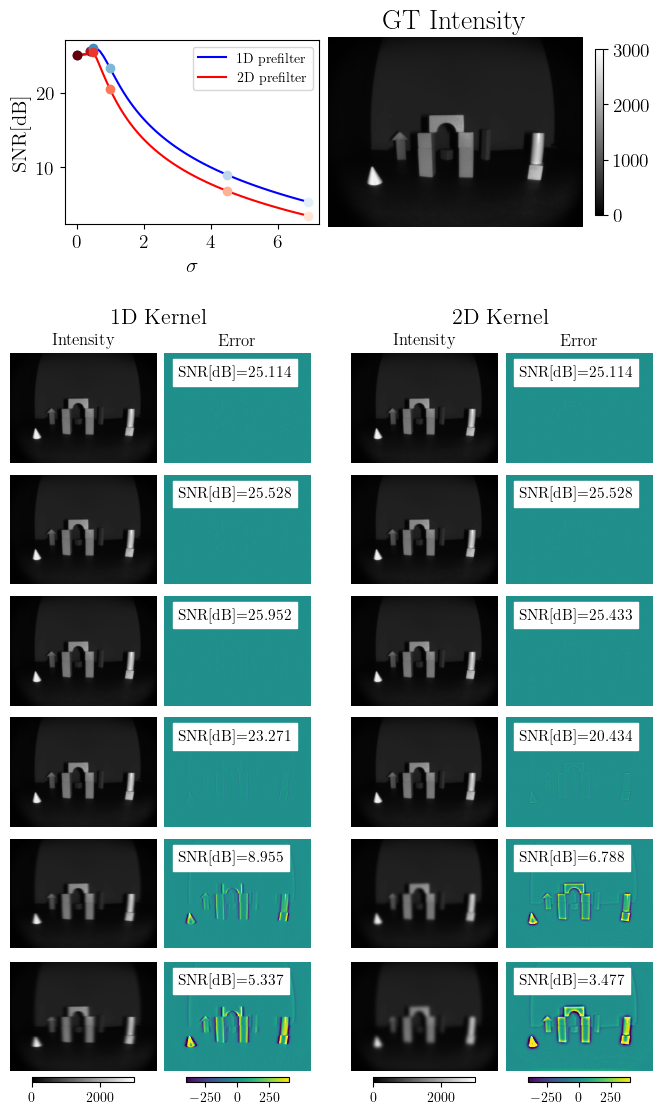

In [12]:
rows = 6
cols = 4
colors_1d = plt.cm.Blues_r(np.linspace(0,0.9,rows))
colors_2d = plt.cm.Reds_r(np.linspace(0,0.9,rows))

fig = plt.figure(layout='constrained', figsize=(6.5, 11))
subfig = fig.subfigures(2,1, height_ratios=[2, 6], hspace=0.05)

row_gts = subfig[0].subplots(1,2)
row_sigmas = subfig[1].subfigures(1, 2, wspace=0.1)

############ gt phase ############
ax = row_gts[1]
ax.set_title("GT Intensity")
im = ax.imshow(intensity_rw, cmap='gray', vmin=0, vmax=3000)
fig.colorbar(im, ax=ax, shrink=0.75)
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )

############ all sigmas ############
ax = row_gts[0]
ax.plot(using_sigmas, snrs_intensity, linewidth=1.5, label="1D prefilter", color='b')
ax.plot(using_sigmas, snrs_intensity2d, linewidth=1.5, label="2D prefilter", color='red')
ax.set_aspect(1/4.5, adjustable='box', anchor='C')

# formatting properties
ax.set_xlabel("$\sigma$")
ax.set_ylabel("SNR[dB]")
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.legend()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# the varying sigmas
temp = np.array([0,4,5])
temp2 = np.arange(10, 60, int(70/(rows-4)))
indices = np.append(temp, temp2)
indices= np.append(indices,[69])
print(indices)

ax1d = row_sigmas[0].subplots(rows, 2)
row_sigmas[0].suptitle("1D Kernel", fontsize=16)
ax2d = row_sigmas[1].subplots(rows, 2)
row_sigmas[1].suptitle("2D Kernel", fontsize=16)

ax1d[0,0].set_title("Intensity", fontsize=12)
ax1d[0,1].set_title("Error", fontsize=12)
ax2d[0,0].set_title("Intensity", fontsize=12)
ax2d[0,1].set_title("Error", fontsize=12)

for r in range(0,rows):
    if r < rows:
        indx = indices[r]
    else:
        indx = indices[r+1]
        
    # make the gradient scatters on the snr plot    
    ax.scatter(using_sigmas[indx], snrs_intensity[indx], color=colors_1d[r], zorder=10)
    ax.scatter(using_sigmas[indx], snrs_intensity2d[indx], color=colors_2d[r],zorder=10)
    
    # plot the reconstructed phases
    im1d = ax1d[r,0].imshow(recon_intensities[indx], cmap='gray', vmin=0, vmax=3000)
    ax1d[r,0].set_axis_off()

    im2d = ax2d[r,0].imshow(recon_intensities2d[indx], cmap='gray', vmin=0, vmax=3000)
    ax2d[r,0].set_axis_off()
    
    # plot the errors
    im1d_err = ax1d[r,1].imshow(diff_intensities[indx], cmap='viridis', vmin=-400, vmax=400)
    ax1d[r,1].annotate("SNR[dB]={:.3f}".format(snrs_intensity[indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax1d[r,1].set_axis_off()

    im2d_err = ax2d[r,1].imshow(diff_intensities2d[indx], cmap='viridis', vmin=-400, vmax=400)
    ax2d[r,1].annotate("SNR[dB]={:.3f}".format(snrs_intensity2d[indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax2d[r,1].set_axis_off()
    
    if r == rows-1:
        cbar1 = row_sigmas[0].colorbar(im1d, ax=ax1d[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar2 = row_sigmas[0].colorbar(im1d_err, ax=ax1d[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        cbar3 = row_sigmas[0].colorbar(im2d, ax=ax2d[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar4 = row_sigmas[0].colorbar(im2d_err, ax=ax2d[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        
        cbar1.ax.tick_params(labelsize=10)
        cbar2.ax.tick_params(labelsize=10)
        cbar3.ax.tick_params(labelsize=10)
        cbar4.ax.tick_params(labelsize=10)

plt.show()

if save_figs:
    fig.savefig("figures/varying_sigmas_intensity.pdf", bbox_inches = 'tight')

#### With Both

[ 0  7 10 27 44 69]


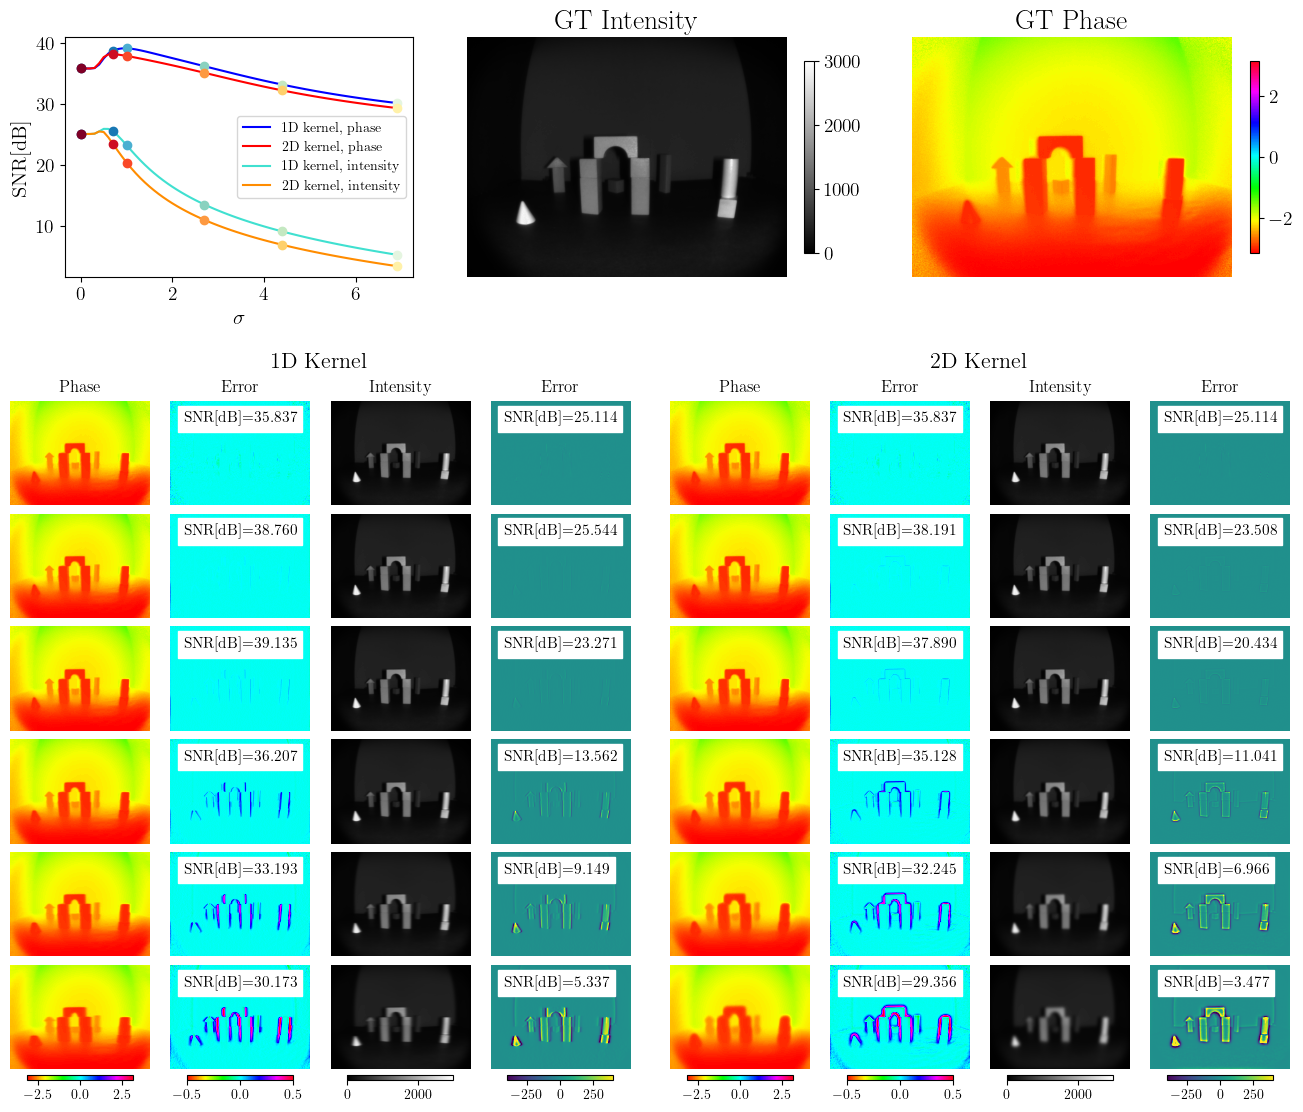

In [13]:
rows = 6
cols = 4
colors_1d = plt.cm.GnBu_r(np.linspace(0,0.9,rows))
colors_2d = plt.cm.YlOrRd_r(np.linspace(0,0.9,rows))

fig = plt.figure(layout='constrained', figsize=(13, 11))
subfig = fig.subfigures(2,1, height_ratios=[2.5, 6], hspace=0.05)

row_gts = subfig[0].subplots(1,3)
row_sigmas = subfig[1].subfigures(1, 2, wspace=0.03)

############ gt phase ############
ax = row_gts[2]
ax.set_title("GT Phase")
im = ax.imshow(phase_rw, cmap='hsv', vmin=-pi, vmax=pi)
fig.colorbar(im, ax=ax, shrink=0.8)
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )
############ gt intensities ############
ax = row_gts[1]
ax.set_title("GT Intensity")
im = ax.imshow(intensity_rw, cmap='gray', vmin=0, vmax=3000)
fig.colorbar(im, ax=ax, shrink=0.8)
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )

############ all sigmas ############
ax = row_gts[0]
ax.plot(using_sigmas, snrs_phase, linewidth=1.5, label="1D kernel, phase", color='b')
ax.plot(using_sigmas, snrs_phase2d, linewidth=1.5, label="2D kernel, phase", color='red')
ax.plot(using_sigmas, snrs_intensity, linewidth=1.5, label="1D kernel, intensity", color='turquoise')
ax.plot(using_sigmas, snrs_intensity2d, linewidth=1.5, label="2D kernel, intensity", color='darkorange')
ax.set_aspect(1/7.5, adjustable='box', anchor='C')

# formatting properties
ax.set_xlabel("$\sigma$")
ax.set_ylabel("SNR[dB]")
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.legend()

############ varying sigmas phase, intensity, errors ############
temp = np.array([0,7])
temp2 = np.arange(10, 60, int(70/(rows-2)))
indices = np.append(temp, temp2)
indices= np.append(indices,[69])
print(indices)

ax1d = row_sigmas[0].subplots(rows, 4)
row_sigmas[0].suptitle("1D Kernel", fontsize=16)
ax2d = row_sigmas[1].subplots(rows, 4)
row_sigmas[1].suptitle("2D Kernel", fontsize=16)

ax1d[0,0].set_title("Phase", fontsize=12)
ax1d[0,1].set_title("Error", fontsize=12)
ax1d[0,2].set_title("Intensity", fontsize=12)
ax1d[0,3].set_title("Error", fontsize=12)

ax2d[0,0].set_title("Phase", fontsize=12)
ax2d[0,1].set_title("Error", fontsize=12)
ax2d[0,2].set_title("Intensity", fontsize=12)
ax2d[0,3].set_title("Error", fontsize=12)

for r in range(0,rows):
    if r < rows:
        indx = indices[r]
    else:
        indx = indices[r+1]
        
    # make the gradient scatters on the snr plot    
    ax.scatter(using_sigmas[indx], snrs_phase[indx], color=colors_1d[r], zorder=10)#, marker=2)
    ax.scatter(using_sigmas[indx], snrs_phase2d[indx], color=colors_2d[r],zorder=10)#, marker=3)
    ax.scatter(using_sigmas[indx], snrs_intensity[indx], color=colors_1d[r], zorder=10)#, marker=2)
    ax.scatter(using_sigmas[indx], snrs_intensity2d[indx], color=colors_2d[r],zorder=10)#, marker=3)
    
    # plot the reconstructed phases
    im1d = ax1d[r,0].imshow(recon_phases[indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax1d[r,0].set_axis_off()

    im2d = ax2d[r,0].imshow(recon_phases2d[indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax2d[r,0].set_axis_off()
    
    # plot the phase errors
    im1d_err = ax1d[r,1].imshow(diff_phases[indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax1d[r,1].annotate("SNR[dB]={:.3f}".format(snrs_phase[indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax1d[r,1].set_axis_off()
    
    im2d_err = ax2d[r,1].imshow(diff_phases2d[indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax2d[r,1].annotate("SNR[dB]={:.3f}".format(snrs_phase2d[indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax2d[r,1].set_axis_off()
    
    # plot the reconstructed intensities
    im1d_int = ax1d[r,2].imshow(recon_intensities[indx], cmap='gray', vmin=0, vmax=3000)
    ax1d[r,2].set_axis_off()

    im2d_int = ax2d[r,2].imshow(recon_intensities2d[indx], cmap='gray', vmin=0, vmax=3000)
    ax2d[r,2].set_axis_off()
    
    # plot the intensities errors
    im1d_int_err = ax1d[r,3].imshow(diff_intensities[indx], cmap='viridis', vmin=-400, vmax=400)
    ax1d[r,3].annotate("SNR[dB]={:.3f}".format(snrs_intensity[indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax1d[r,3].set_axis_off()
    
    im2d_int_err = ax2d[r,3].imshow(diff_intensities2d[indx], cmap='viridis', vmin=-400, vmax=400)
    ax2d[r,3].annotate("SNR[dB]={:.3f}".format(snrs_intensity2d[indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax2d[r,3].set_axis_off()
    
    if r == rows-1:
        cbar1 = row_sigmas[0].colorbar(im1d, ax=ax1d[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar2 = row_sigmas[0].colorbar(im1d_err, ax=ax1d[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        cbar3 = row_sigmas[0].colorbar(im2d, ax=ax2d[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar4 = row_sigmas[0].colorbar(im1d_err, ax=ax2d[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        cbar5 = row_sigmas[0].colorbar(im1d_int, ax=ax1d[r,2], orientation='horizontal', location='bottom', shrink=0.7)
        cbar6 = row_sigmas[0].colorbar(im1d_int_err, ax=ax1d[r,3], orientation='horizontal', location='bottom', shrink=0.7)
        cbar7 = row_sigmas[0].colorbar(im2d_int, ax=ax2d[r,2], orientation='horizontal', location='bottom', shrink=0.7)
        cbar8 = row_sigmas[0].colorbar(im1d_int_err, ax=ax2d[r,3], orientation='horizontal', location='bottom', shrink=0.7)
        
        cbar1.ax.tick_params(labelsize=10)
        cbar2.ax.tick_params(labelsize=10)
        cbar3.ax.tick_params(labelsize=10)
        cbar4.ax.tick_params(labelsize=10)
        cbar5.ax.tick_params(labelsize=10)
        cbar6.ax.tick_params(labelsize=10)
        cbar7.ax.tick_params(labelsize=10)
        cbar8.ax.tick_params(labelsize=10)
        
plt.show()

if save_figs:
    fig.savefig("figures/varying_sigmas_both.pdf", bbox_inches = 'tight')